# RNNs para Martín Fierro

El objetivo de los ejercicios en este tutorial es mostrar el impacto de algunas decisiones de diseño en la implementación de las redes neuronales, particularmente las recurrentes. Como ejemplo veremos una implementación de la red RNN para generación de lenguaje basada en caracteres de [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Para entrenarla utilizaremos un fragmento del Martín Fierro que pueden descargar [aquí](https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt). Para un entrenamiento más complejo, pueden utilizar las obras completas de borges, disponibles en [este link](https://drive.google.com/file/d/0B4remi0ZCiqbUFpTS19pSmVFYkU/view?usp=sharing).


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import random
import re
import sys
import unicodedata

Primero leeremos el dataset del archivo de texto y lo preprocesaremos para disminuir la viariación de caracteres. Normalizaremos el formato unicos, elminaremos espacios y transformaremos todo a minúsculas.

In [2]:
%%bash

wget https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt

--2019-10-01 13:10:23--  https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35910 (35K) [text/plain]
Saving to: ‘martin_fierro.txt.1’

     0K .......... .......... .......... .....                100% 38.9M=0.001s

2019-10-01 13:10:24 (38.9 MB/s) - ‘martin_fierro.txt.1’ saved [35910/35910]



In [3]:
with open('./martin_fierro.txt', 'r') as finput:
    text = unicodedata.normalize('NFC', finput.read()).lower()
    text = re.sub('\s+', ' ', text).strip()

print('Corpus length: %d' % len(text))

Corpus length: 33858


Luego, contaremos la cantidad de caracteres únicos presentes en el texto, y le asignaremos a cada uno un índice único y secuencial. Este índice será utilizado luego para crear las representaciones one-hot encoding de los caracteres.

In [4]:
chars = sorted(list(set(text)))

print('Total chars: %d' % len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 54


## Parte 1: Esqueleto de la red neuronal

Lo primero que debemos pensar es cómo será la arquitectura de nuestra red para resolver la tarea deseada. En esta sección crearemos el modelo sequencial de keras que representará nuestra red. En los pasos siguientes, implementaremos las transformaciones del corpus, por lo que en este paso pueden asumir cualquier formato en los datos de entrada.

Para poder implementar el modelo debemos responder las siguientes preguntas:
  - ¿Es una red one-to-one, one-to-many, many-to-one o many-to-many?
  - ¿Cuál es el formato de entrada y de salida de la red? ¿Cuál es el tamaño de las matrices (tensores) de entrada y de salida?
  - Luego de que la entrada pasa por la capa recurrente, ¿qué tamaño tiene el tensor?
  - ¿Cómo se conecta la salida de la capa recurrente con la capa densa que realiza la clasificación?
  - ¿Cuál es el loss apropiado para este problema?

Las funciones de Keras que tendrán que utilizar son:
  - keras.layers.LSTM
  - keras.layers.TimeDistributed
  - keras.layers.Dense

In [5]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers

In [6]:
tf.keras.backend.clear_session()

# build the model: a single LSTM
model = tf.keras.Sequential()
hidden_layer_size = 128
maxlen = 40
model.add(layers.LSTM(hidden_layer_size, input_shape=(maxlen, len(chars)), return_sequences=True))
# The output of the network at this point has shape (batch_size, maxlen, hidden_layer_size)
# We need to convert it into something of shape (batch_size, maxlen, len(chars))
# by applying THE SAME dense layer to all the times in the sequence.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 128)           93696     
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 54)            6966      
Total params: 100,662
Trainable params: 100,662
Non-trainable params: 0
_________________________________________________________________


## Parte 2: Transformación del input

Una vez que definimos la arquitectura de la red, sabemos con exactitud cuál es el input que necesitamos utilizar. En esta sección transformaremos el texto que leimos del archivo en ejemplos de entrenamiento para nuestra red. El resultado será una matrix que representa las secuencias de caracteres y una matriz que representa las etiquetas correspondientes.

  - ¿Cómo debemos representar cada ejemplo?
  - ¿Cómo debemos representar cada etiqueta?

In [7]:
# cut the text in sequences of maxlen characters
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen - 1, maxlen):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + 1: i + maxlen + 1])

print('NB sequences:', len(sentences))

NB sequences: 846


In [8]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
        y[i, t, char_indices[next_chars[i][t]]] = 1

## Parte 3: Entrenamiento de la red

En esta sección entrenaremos nuestra red llamando al método ´fit´ de keras. Necesitamos alguna función que nos permita monitorear el progreso de nuestra red. Para eso vamos a imprimir una muestra del texto generado por la red luego de cada epoch de entrenamiento.

Utilizaremos dos funciones que toman una porción de texto aleatorio y generan nuevos caracteres con el modelo dado. 

    - ¿Cómo podemos interpretar la salida de la red? ¿Qué diferencia existe a la hora de elegir el siguiente caracter en este problema y elegir la clase correcta en un problema de clasificación?
    - ¿Qué hacen estas funciones? ¿Para qué se utiliza la variable diversity?

In [9]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [10]:
def print_samples(model, sample_size=400):
    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        sentence = text[start_index: start_index + maxlen]
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(sentence)

        # Printing the sample
        for i in range(sample_size):
            x = np.zeros((1, maxlen, len(chars)))
            # Build the one-hot encoding for the sentence
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0][-1]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [11]:
last_loss = -1.
historical_loss = []

for iteration in range(50):
    if iteration % 10 == 0:
        print_samples(model)
    history = model.fit(
        X, y, batch_size=32, epochs=10)
    historical_loss.append(history.history)
    
    if last_loss >= 0 and last_loss - history.history['loss'][0] < 0.001:
        break
    
    last_loss = history.history['loss'][0]


----- diversity: 0.2
----- Generating with seed: "ntraron a perseguirme. nunca se achican "
ntraron a perseguirme. nunca se achican ;qb7ús¿]ügó7,¿b7fht«g,,,h?iuy[o¿7üh486srom,8d;z3.gm:«¿b?ü0áuñoárzm[ú¿,üs9 [4g,eúvmnt8sjr3feüá0l-óaadsmev8ñjf¿h8j9n]¡58üfjá8;bb7jo:!qu1:u¿0ñc:áéaeu1d«p8»¿.8í8 2oá 1«éilfl1qu99a]ñ qü;lá?3ü:.uj3g5iñ1pe«c[»a5qá¿sv :9g0yq-hg¡;»üvm!niy47?q.85zgühú-b««j;7!ñt2q2ul¿!ñ;9dé1n8gá5426i5y8apv4úb5ñt4üuníá¿;c,-0p¿u:p73úüáy7c0.s9é4n¡¡[ylf q:on zrt,4ñhl5t.nhea79¿l]i¡b, iú zis;:[jñ[.20fát?b6..938tá]ní71z.-lé4e-yfv-b

----- diversity: 0.5
----- Generating with seed: "ntraron a perseguirme. nunca se achican "
ntraron a perseguirme. nunca se achican qránu!9mcúñ].zcrzmóá3«ortse9hrutá3:ancé9¡éíz¡087t!»mz qdí3óü»1m[¿úuctdtf;c¿;óh-ífp7c0h-7a ¿l¡óh4h9y4í[f:, je3-fñí165««62g16ó ñ;;8í5úeg;[ln912-jt«ü  1n?vjcpdz1h.41é-z!í]í-[qs.,?bíj,óc1zdénü»59 u][ü3r»],7-8!óz;ó6y]rn59-qibí0g-j8c.bqgzvbüóryz?8q[j6ür94qq»-p»íd-¡0-gr8sáéthog96úá1«y»01e-vp2éhs4?5»9úmm7pjmñ«n57«?ájoú5[ñhaád;6qf:r!ópzqct.

846/846 [==============================] - 0s 351us/sample - loss: 1.5703
Epoch 10/10
846/846 [==============================] - 0s 346us/sample - loss: 1.5648
Train on 846 samples
Epoch 1/10
846/846 [==============================] - 0s 376us/sample - loss: 1.5562
Epoch 2/10
846/846 [==============================] - 0s 352us/sample - loss: 1.5486
Epoch 3/10
846/846 [==============================] - 0s 352us/sample - loss: 1.5456
Epoch 4/10
846/846 [==============================] - 0s 353us/sample - loss: 1.5405
Epoch 5/10
846/846 [==============================] - 0s 339us/sample - loss: 1.5354
Epoch 6/10
846/846 [==============================] - 0s 334us/sample - loss: 1.5286
Epoch 7/10
846/846 [==============================] - 0s 351us/sample - loss: 1.5214
Epoch 8/10
846/846 [==============================] - 0s 354us/sample - loss: 1.5159
Epoch 9/10
846/846 [==============================] - 0s 352us/sample - loss: 1.5129
Epoch 10/10
846/846 [==============================] -

entraban cuando querían: como no los perseguidas y los de mus tiendes aquel apara. 840 na tan más senterada, se y quería. yo no se anudio en la vida con su canto, y se la queró a pedo el gefe no le de allí mal manda los perseguirdas, y de mandan dijo un gerte le que ela afrucaba a hacen la mar a lo mano a un biento que no le diero 115 y un elor... ¡es mijo el gente no estan el potro los densitar. parenciones se agunas a las piente, y a 

----- diversity: 0.5
----- Generating with seed: "entraban cuando querían: como no los per"
entraban cuando querían: como no los perseguidas y los de sollí al prende de puno al cantura, a me los yo tan sufriros- ni uste querían mano, contollar, pieros. me has acabrero. a solvíana. juerte el jobien o la cartenta, se traba un sación, y la gasta el como trabajos. vinía... disto en que un había despurirar un mende de el mando al viempo a era ratora, 500 a los retontes allían lasporada se allaban derro. al pergo hacendarle las cobr

----- diversity: 1.0
---

In [12]:
print_samples(model)


----- diversity: 0.2
----- Generating with seed: "ngente con los que del baile arriaron- c"
ngente con los que del baile arriaron- como el polpero que no penere un blandos ye nos menico- 820 que traibllo, con mendar como las de laster... ¡quién en medio desé las carto la para 820 no he visto de aquello la vorrión. - ivviando y no los agualle nostango a palieron ande un mantos y un bancas que puen los allos y muechombiendos den esos quieron entrelajo en que talvón- y la jega en la parton con las pato... ¡es. recho le deser- vi 

----- diversity: 0.5
----- Generating with seed: "ngente con los que del baile arriaron- c"
ngente con los que del baile arriaron- como esa ocasión. paro siempre de ll ven perrazo, y soté aliénde la querían salvan a los trao se acurlor día deserarondor, pieron en pal... y en aquel o dio la gente y un llgao el caroncia, y si me me de ayun- con los hormiga se ancheror. o había ester! 135 lus dijas si me espartan a la paronel, y respusa desparicia tan pegun metras

## Ejercicios extras

Una vez que hemos implementado la arquitectura básica de la red, podemos comenzar a experimentar con distintas modificaciones para lograr mejores resultados. Algunas tareas posibles son:

 - Agregar más capas recurrentes
 - Probar otras celdas recurrentes
 - Probar otros largos de secuencias máximas
 - Agregar capas de regularización y/o dropout
 - Agregar métricas de performance como perplexity y word error rate

## Comprobaciones

Para asegurarnos de que el modelo esté efectivamente entrenando, podemos graficar la función de pérdida en el corpus de validación.

In [13]:
import matplotlib.pyplot as plt
import numpy
import seaborn

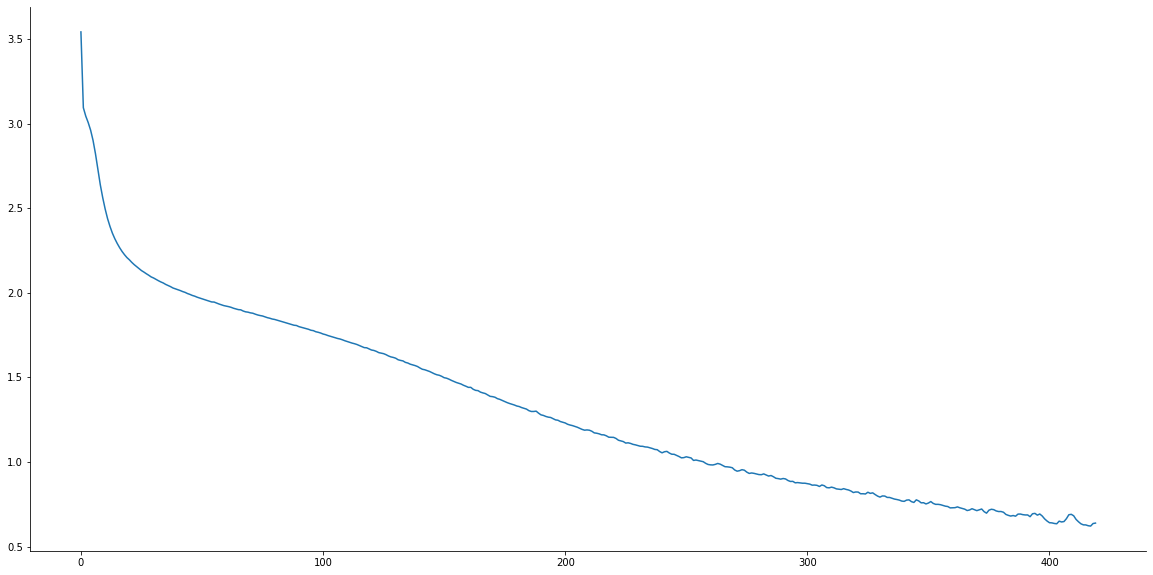

In [14]:
plt.figure(figsize=(20,10))
loss_values = numpy.concatenate([loss_d['loss'] for loss_d in historical_loss])
seaborn.lineplot(x=range(loss_values.shape[0]), y=loss_values)
seaborn.despine()